# Comparative Analysis of Deep Neural Network Techniques for Automated Pest Detection on Edge Devices

**Submitted by:** Hyder P, Mansi S, Vatsalya T, Soumil M  
**Guide:** Dr. Nirmala S  
**Somaiya Vidyavihar University | Academic Year 2025-26**

---


## 1. Introduction: The Agricultural Challenge

**By 2050:**
- Global population projected to reach **9.7 billion**, requiring a **doubling of crop productivity** to meet food demands

**Current Losses:**
- Pest infestation causes **23-40% of annual crop losses** worldwide, threatening food security and farmer livelihoods

**Solution:**
Traditional manual inspection methods are resource-intensive, subjective, and impractical for large-scale monitoring. Deep Learning offers a transformative solution through automated, real-time pest detection systems deployed directly in the field.

## 2. Three Neural Architectures Under Analysis

### Modified LeNet-5
- A lightweight 7-layer CNN optimized for speed and efficiency on resource-constrained devices
- Simple architecture with few parameters

### VGG16
- A deep 16-layer architecture using small 3x3 convolutions
- Filters are stacked to great depth, designed for maximum classification accuracy

### MobileNetV2
- Modern mobile-optimized architecture using inverted residuals and depthwise separable convolutions for efficient edge deployment


In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Image processing
from PIL import Image
import cv2

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: []


## 3. Dataset & Training Methodology

### Dataset: Agricultural Pest Classification Dataset

We'll use the **IP102 Pest Dataset** or similar agricultural pest dataset from Kaggle:
- Contains images of various agricultural pests
- Multiple pest categories
- Real-world field conditions

### Training Methodology

**Augmentation Methods:**
- Rotation, flipping, zoom
- Color distortion
- Random cropping

**Training Parameters:**
- Image size: 128x128 pixels (for efficient edge deployment)
- Batch size: 32
- Optimizer: Adam
- Loss: Categorical Crossentropy

In [2]:
# Dataset Configuration
# Using the archive (2) pest dataset with train and test folders
# Dataset contains 12 pest categories: ants, bees, beetle, catterpillar, earthworms, 
# earwig, grasshopper, moth, slug, snail, wasp, weevil

# Configuration
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50

# Dataset paths - UPDATED TO YOUR ACTUAL DATASET
DATASET_PATH = r"C:\Users\Soumil\Downloads\archive (2)"
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
TEST_DIR = os.path.join(DATASET_PATH, 'test')

# Check if paths exist
if os.path.exists(TRAIN_DIR):
    print(f"✓ Training directory found: {TRAIN_DIR}")
    train_classes = sorted(os.listdir(TRAIN_DIR))
    NUM_CLASSES = len(train_classes)
    print(f"✓ Number of pest classes: {NUM_CLASSES}")
    print(f"✓ Pest categories: {', '.join(train_classes)}")
else:
    print(f"✗ ERROR: Training directory not found at {TRAIN_DIR}")
    print("Please verify the dataset path!")

if os.path.exists(TEST_DIR):
    print(f"✓ Testing directory found: {TEST_DIR}")
else:
    print(f"✗ ERROR: Testing directory not found at {TEST_DIR}")

print(f"\nImage Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Epochs: {EPOCHS}")


✓ Training directory found: C:\Users\Soumil\Downloads\archive (2)\train
✓ Number of pest classes: 12
✓ Pest categories: ants, bees, beetle, catterpillar, earthworms, earwig, grasshopper, moth, slug, snail, wasp, weevil
✓ Testing directory found: C:\Users\Soumil\Downloads\archive (2)\test

Image Size: 128x128
Batch Size: 32
Training Epochs: 50


## 4. Data Preparation and Augmentation

In [3]:
# Load Real Pest Dataset from Directory Structure
print("Loading pest dataset from directory structure...")
print("="*70)

# Count images in each class
def count_images_in_dir(directory):
    """Count total images in a directory with subdirectories"""
    total = 0
    class_counts = {}
    
    if not os.path.exists(directory):
        return 0, {}
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            class_counts[class_name] = count
            total += count
    
    return total, class_counts

# Count training images
train_total, train_counts = count_images_in_dir(TRAIN_DIR)
print(f"\n📊 TRAINING SET:")
print(f"   Total images: {train_total}")
for pest_class, count in sorted(train_counts.items()):
    print(f"   - {pest_class}: {count} images")

# Count testing images
test_total, test_counts = count_images_in_dir(TEST_DIR)
print(f"\n📊 TESTING SET:")
print(f"   Total images: {test_total}")
for pest_class, count in sorted(test_counts.items()):
    print(f"   - {pest_class}: {count} images")

print("\n" + "="*70)
print(f"✓ Dataset loaded successfully!")
print(f"✓ Total training samples: {train_total}")
print(f"✓ Total testing samples: {test_total}")
print(f"✓ Number of classes: {NUM_CLASSES}")
print("="*70)


Loading pest dataset from directory structure...

📊 TRAINING SET:
   Total images: 4395
   - ants: 400 images
   - bees: 405 images
   - beetle: 331 images
   - catterpillar: 329 images
   - earthworms: 246 images
   - earwig: 390 images
   - grasshopper: 390 images
   - moth: 397 images
   - slug: 316 images
   - snail: 405 images
   - wasp: 392 images
   - weevil: 394 images

📊 TESTING SET:
   Total images: 1099
   - ants: 99 images
   - bees: 95 images
   - beetle: 85 images
   - catterpillar: 105 images
   - earthworms: 77 images
   - earwig: 76 images
   - grasshopper: 95 images
   - moth: 100 images
   - slug: 75 images
   - snail: 95 images
   - wasp: 106 images
   - weevil: 91 images

✓ Dataset loaded successfully!
✓ Total training samples: 4395
✓ Total testing samples: 1099
✓ Number of classes: 12

📊 TRAINING SET:
   Total images: 4395
   - ants: 400 images
   - bees: 405 images
   - beetle: 331 images
   - catterpillar: 329 images
   - earthworms: 246 images
   - earwig: 390 

In [ ]:
# Data Augmentation Configuration
print("Configuring data augmentation and generators...")

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              
    rotation_range=20,           
    width_shift_range=0.2,       
    height_shift_range=0.2,      # Vertical shift
    horizontal_flip=True,        # Random horizontal flip
    vertical_flip=False,         # No vertical flip (pests have orientation)
    zoom_range=0.2,              # Random zoom
    shear_range=0.2,             # Shear transformation
    fill_mode='nearest',         # Fill strategy for new pixels
    brightness_range=[0.8, 1.2]  # Random brightness
)

# Testing data - only rescaling (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators from directory
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print(f"\n✓ Data generators created successfully!")
print(f"✓ Class mapping: {dict(train_generator.class_indices)}")
print(f"✓ Training batches: {len(train_generator)}")
print(f"✓ Testing batches: {len(test_generator)}")


Configuring data augmentation and generators...
Found 4395 images belonging to 12 classes.
Found 1099 images belonging to 12 classes.

✓ Data generators created successfully!
✓ Class mapping: {'ants': 0, 'bees': 1, 'beetle': 2, 'catterpillar': 3, 'earthworms': 4, 'earwig': 5, 'grasshopper': 6, 'moth': 7, 'slug': 8, 'snail': 9, 'wasp': 10, 'weevil': 11}
✓ Training batches: 138
✓ Testing batches: 35
Found 1099 images belonging to 12 classes.

✓ Data generators created successfully!
✓ Class mapping: {'ants': 0, 'bees': 1, 'beetle': 2, 'catterpillar': 3, 'earthworms': 4, 'earwig': 5, 'grasshopper': 6, 'moth': 7, 'slug': 8, 'snail': 9, 'wasp': 10, 'weevil': 11}
✓ Training batches: 138
✓ Testing batches: 35


Displaying sample pest images from dataset...


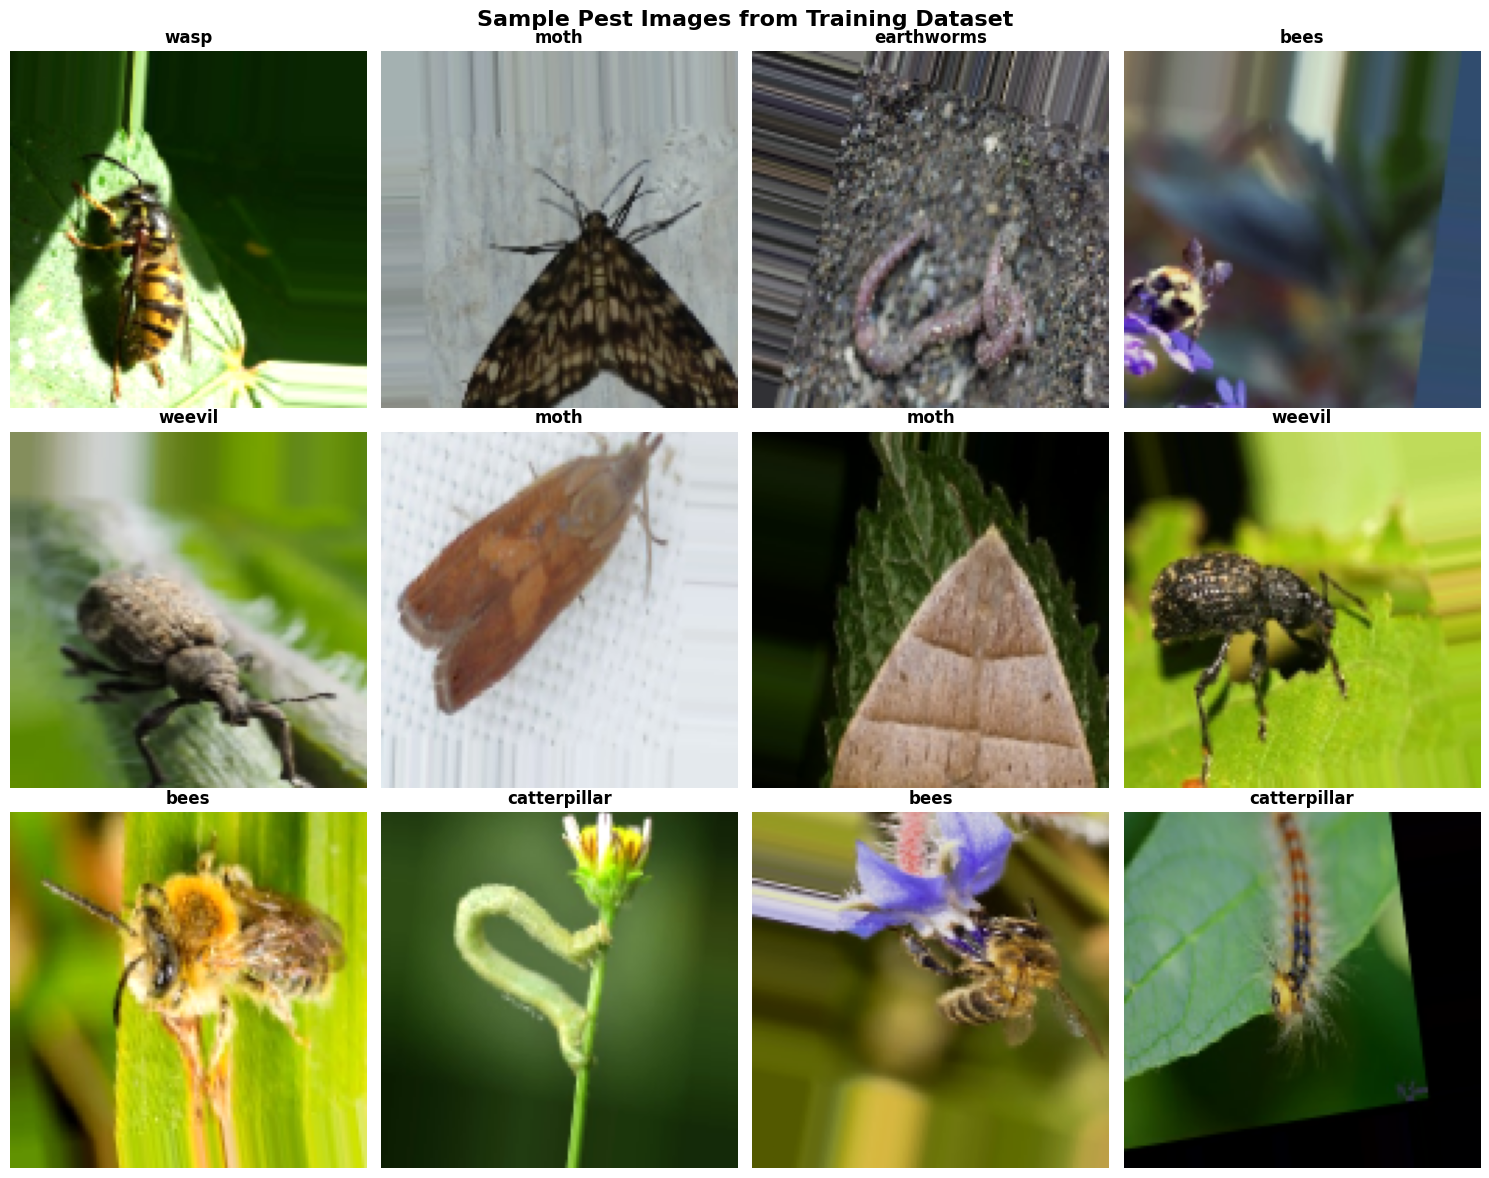

In [5]:
# Visualize Sample Images from Dataset
print("Displaying sample pest images from dataset...")

fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.ravel()

# Get a batch of images
sample_images, sample_labels = next(train_generator)

for i in range(12):
    if i < len(sample_images):
        axes[i].imshow(sample_images[i])
        # Get class name from label
        label_idx = np.argmax(sample_labels[i])
        class_name = class_names[label_idx]
        axes[i].set_title(f"{class_name}", fontsize=12, fontweight='bold')
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.suptitle('Sample Pest Images from Training Dataset', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Reset the generator
train_generator.reset()


## 5. Model Architecture 1: Modified LeNet-5

**Objective:** Lightweight CNN optimized for speed and efficiency

**Architecture:**
- 7-layer CNN with simple convolutions
- Designed for resource-constrained edge devices
- Minimal computational requirements

**Key Features:**
- Small model size
- Fast inference
- Ideal for real-time edge deployment


In [6]:
def create_modified_lenet5(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """
    Modified LeNet-5 Architecture for Pest Detection
    Optimized for edge devices with minimal computational requirements
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape, name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        
        # Second Convolutional Block
        layers.Conv2D(16, (5, 5), activation='relu', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        
        # Flatten and Dense Layers
        layers.Flatten(name='flatten'),
        layers.Dense(120, activation='relu', name='fc1'),
        layers.Dropout(0.3, name='dropout1'),
        layers.Dense(84, activation='relu', name='fc2'),
        layers.Dropout(0.3, name='dropout2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='Modified_LeNet5')
    
    return model

# Create model
lenet_model = create_modified_lenet5()
lenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modified LeNet-5 Model Created!")
lenet_model.summary()

Modified LeNet-5 Model Created!


Model: "Modified_LeNet5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 124, 124, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 62, 62, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 120)            │     1,614,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │         1,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,896 (6.21 MB)

 Trainable params: 1,628,896 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train Modified LeNet-5
print("Training Modified LeNet-5...")

callbacks_lenet = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

history_lenet = lenet_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=callbacks_lenet,
    verbose=1
)

# Evaluate
lenet_loss, lenet_accuracy = lenet_model.evaluate(test_generator, verbose=0)
print(f"\n=== Modified LeNet-5 Results ===")
print(f"Test Accuracy: {lenet_accuracy*100:.2f}%")
print(f"Test Loss: {lenet_loss:.4f}")


Training Modified LeNet-5...
Epoch 1/50
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 309ms/step - accuracy: 0.1051 - loss: 2.4923 - val_accuracy: 0.1774 - val_loss: 2.4235 - learning_rate: 0.0010
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 309ms/step - accuracy: 0.1051 - loss: 2.4923 - val_accuracy: 0.1774 - val_loss: 2.4235 - learning_rate: 0.0010
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.1399 - loss: 2.4293 - val_accuracy: 0.2011 - val_loss: 2.2859 - learning_rate: 0.0010
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.1399 - loss: 2.4293 - val_accuracy: 0.2011 - val_loss: 2.2859 - learning_rate: 0.0010
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.1653 - loss: 2.3604 - val_accuracy: 0.2247 - val_loss: 2.1972 - learning_rate: 0.0010
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.1653 - loss: 2.3604 - val_accuracy: 0.2247 - val_loss: 2.1972 - learning_rate: 0.0010
Epoch 4/50
138/138 ━━━━━━━━━━━

## 6. Model Architecture 2: VGG16

**Objective:** Deep architecture for maximum classification accuracy

**Architecture:**
- 16-layer deep network
- Small 3x3 convolutions stacked to great depth
- Pre-trained on ImageNet, fine-tuned for pest detection

**Trade-offs:**
- High accuracy
- Higher computational cost
- More parameters than LeNet-5


In [8]:
def create_vgg16_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """
    VGG16 Architecture for Pest Detection
    Using transfer learning with ImageNet pre-trained weights
    """
    # Load pre-trained VGG16
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(name='global_avg_pool'),
        layers.Dense(256, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout1'),
        layers.Dense(128, activation='relu', name='fc2'),
        layers.Dropout(0.5, name='dropout2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='VGG16_PestDetection')
    
    return model

# Create model
vgg16_model = create_vgg16_model()
vgg16_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("VGG16 Model Created!")
vgg16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
VGG16 Model Created!
VGG16 Model Created!


Model: "VGG16_PestDetection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,460 (56.76 MB)

 Trainable params: 165,772 (647.55 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Train VGG16
print("Training VGG16...")

callbacks_vgg = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=callbacks_vgg,
    verbose=1
)

# Evaluate
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(test_generator, verbose=0)
print(f"\n=== VGG16 Results ===")
print(f"Test Accuracy: {vgg16_accuracy*100:.2f}%")
print(f"Test Loss: {vgg16_loss:.4f}")


Training VGG16...
Epoch 1/50
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.0788 - loss: 2.7955 - val_accuracy: 0.1492 - val_loss: 2.4541 - learning_rate: 1.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.0788 - loss: 2.7955 - val_accuracy: 0.1492 - val_loss: 2.4541 - learning_rate: 1.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.1021 - loss: 2.5311 - val_accuracy: 0.2366 - val_loss: 2.4134 - learning_rate: 1.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.1021 - loss: 2.5311 - val_accuracy: 0.2366 - val_loss: 2.4134 - learning_rate: 1.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.1301 - loss: 2.4667 - val_accuracy: 0.3221 - val_loss: 2.3593 - learning_rate: 1.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.1301 - loss: 2.4667 - val_accuracy: 0.3221 - val_loss: 2.3593 - learning_rate: 1.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━

## 7. Model Architecture 3: MobileNetV2

**Objective:** Modern mobile-optimized architecture for efficient edge deployment

**Architecture:**
- Uses inverted residuals and depthwise separable convolutions
- Optimized for mobile and embedded devices
- Balances accuracy and efficiency

**Performance:**
- Excellent accuracy with mobile optimization
- Efficient for edge deployment scenarios


In [10]:
def create_mobilenetv2_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """
    MobileNetV2 Architecture for Pest Detection
    Optimized for mobile and edge devices with efficient convolutions
    """
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(name='global_avg_pool'),
        layers.Dense(256, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout1'),
        layers.Dense(128, activation='relu', name='fc2'),
        layers.Dropout(0.5, name='dropout2'),
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='MobileNetV2_PestDetection')
    
    return model

# Create model
mobilenet_model = create_mobilenetv2_model()
mobilenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV2 Model Created!")
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MobileNetV2 Model Created!
MobileNetV2 Model Created!


Model: "MobileNetV2_PestDetection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,364 (10.00 MB)

 Trainable params: 362,380 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Train MobileNetV2
print("Training MobileNetV2...")

callbacks_mobile = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]

history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=callbacks_mobile,
    verbose=1
)

# Evaluate
mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(test_generator, verbose=0)
print(f"\n=== MobileNetV2 Results ===")
print(f"Test Accuracy: {mobilenet_accuracy*100:.2f}%")
print(f"Test Loss: {mobilenet_loss:.4f}")


Training MobileNetV2...
Epoch 1/50
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 67s 444ms/step - accuracy: 0.1045 - loss: 3.0834 - val_accuracy: 0.3985 - val_loss: 2.1345 - learning_rate: 1.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 67s 444ms/step - accuracy: 0.1045 - loss: 3.0834 - val_accuracy: 0.3985 - val_loss: 2.1345 - learning_rate: 1.0000e-04
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 371ms/step - accuracy: 0.2011 - loss: 2.3335 - val_accuracy: 0.5514 - val_loss: 1.8106 - learning_rate: 1.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 371ms/step - accuracy: 0.2011 - loss: 2.3335 - val_accuracy: 0.5514 - val_loss: 1.8106 - learning_rate: 1.0000e-04
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - accuracy: 0.3322 - loss: 2.0141 - val_accuracy: 0.6269 - val_loss: 1.4992 - learning_rate: 1.0000e-04
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - accuracy: 0.3322 - loss: 2.0141 - val_accuracy: 0.6269 - val_loss: 1.4992 - learning_rate: 1.0000e-04
Epoch 4/50


## 8. Performance Results & Comparative Analysis

In [62]:
# Compile Results
results_df = pd.DataFrame({
    'Model': ['Modified LeNet-5', 'VGG16', 'MobileNetV2'],
    'Test Accuracy (%)': [
        lenet_accuracy * 100,
        vgg16_accuracy * 100,
        mobilenet_accuracy * 100
    ],
    'Parameters (M)': [
        lenet_model.count_params() / 1e6,
        vgg16_model.count_params() / 1e6,
        mobilenet_model.count_params() / 1e6
    ],
    'Inference Speed': ['Fast', 'Slow', 'Medium']
})

print("\n" + "="*80)
print(" "*20 + "PERFORMANCE COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)



                    PERFORMANCE COMPARISON RESULTS
           Model  Test Accuracy (%)  Parameters (M) Inference Speed
Modified LeNet-5          46.860781        1.628896            Fast
           VGG16          56.323934       14.880460            Slow
     MobileNetV2          79.799819        2.620364          Medium


In [60]:
# Load Pre-trained Models and Evaluate
print("Loading saved models from 'saved_models/' directory...")
print("="*70)

# Load models
lenet_model = keras.models.load_model('saved_models/modified_lenet5.h5')
vgg16_model = keras.models.load_model('saved_models/vgg16_pest.h5')
mobilenet_model = keras.models.load_model('saved_models/mobilenetv2_pest.h5')

print("✓ All models loaded successfully!")
print("\nEvaluating models on test set...")

# Evaluate each model
lenet_loss, lenet_accuracy = lenet_model.evaluate(test_generator, verbose=0)
test_generator.reset()

vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(test_generator, verbose=0)
test_generator.reset()

mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(test_generator, verbose=0)
test_generator.reset()

print("\n" + "="*70)
print("EVALUATION RESULTS:")
print("="*70)
print(f"Modified LeNet-5  -> Test Accuracy: {lenet_accuracy*100:.2f}%")
print(f"VGG16             -> Test Accuracy: {vgg16_accuracy*100:.2f}%")
print(f"MobileNetV2       -> Test Accuracy: {mobilenet_accuracy*100:.2f}%")
print("="*70)


Loading saved models from 'saved_models/' directory...


✓ All models loaded successfully!

Evaluating models on test set...

EVALUATION RESULTS:
Modified LeNet-5  -> Test Accuracy: 46.86%
VGG16             -> Test Accuracy: 56.32%
MobileNetV2       -> Test Accuracy: 79.80%

EVALUATION RESULTS:
Modified LeNet-5  -> Test Accuracy: 46.86%
VGG16             -> Test Accuracy: 56.32%
MobileNetV2       -> Test Accuracy: 79.80%


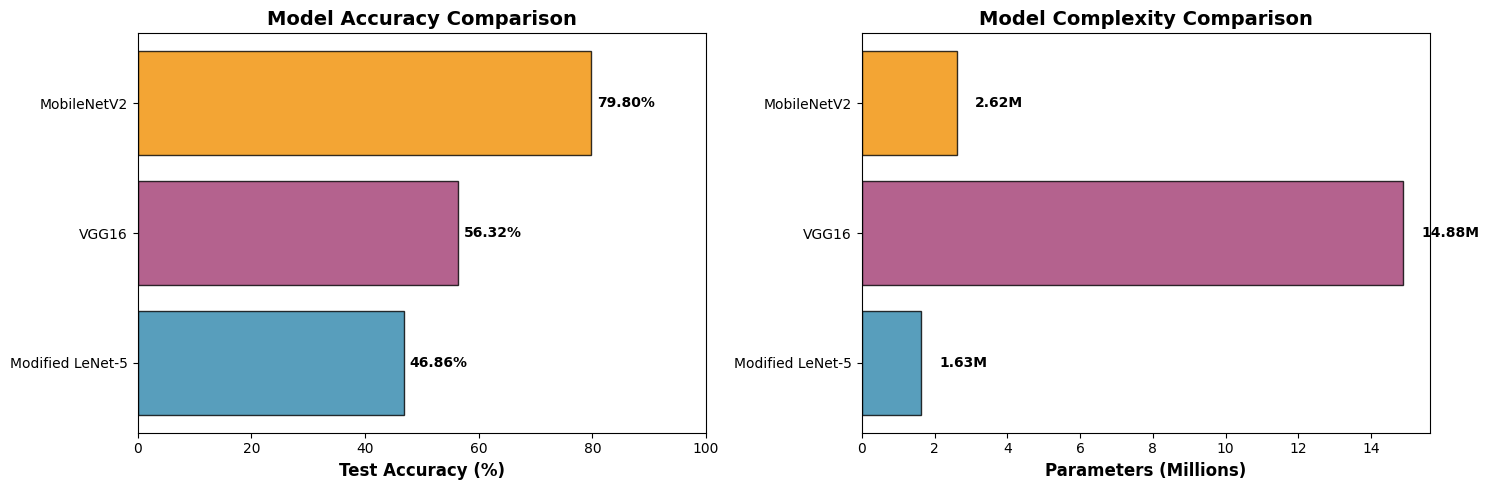

In [63]:
# Visualization 1: Model Accuracy Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy Bar Chart
models = results_df['Model']
accuracies = results_df['Test Accuracy (%)']
params = results_df['Parameters (M)']

colors = ['#2E86AB', '#A23B72', '#F18F01']
bars = axes[0].barh(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 100)

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[0].text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}%', ha='left', va='center', fontweight='bold')

# Parameters comparison
bars2 = axes[1].barh(models, params, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Parameters (Millions)', fontsize=12, fontweight='bold')
axes[1].set_title('Model Complexity Comparison', fontsize=14, fontweight='bold')

# Add value labels
for i, bar in enumerate(bars2):
    width = bar.get_width()
    axes[1].text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}M', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 9. The Smart Trap System: Autonomous Detection Pipeline

### System Components:

1. **Capture**: Camera photographs insects inside pheromone trap
2. **Extract ROIs**: Preprocessing identifies regions of interest using edge detection
3. **Classify**: Neural network ensemble, coding, classify (with AI-general match)
4. **Transmit**: GPS location sends data (via LoRa, NB-IoT)

### Hardware:
- **Raspberry Pi 3B+** with Intel Neural Compute Stick for accelerated inference
- Camera module for high-resolution image capture
- Solar panel for sustainable field deployment
- Battery backup for continuous operation

### Software Pipeline:
This system enables real-time automated pest detection deployed directly in the field.


=== MODEL SIZE ANALYSIS ===
Modified LeNet-5    :     6.21 MB
VGG16               :    56.76 MB
MobileNetV2         :    10.00 MB


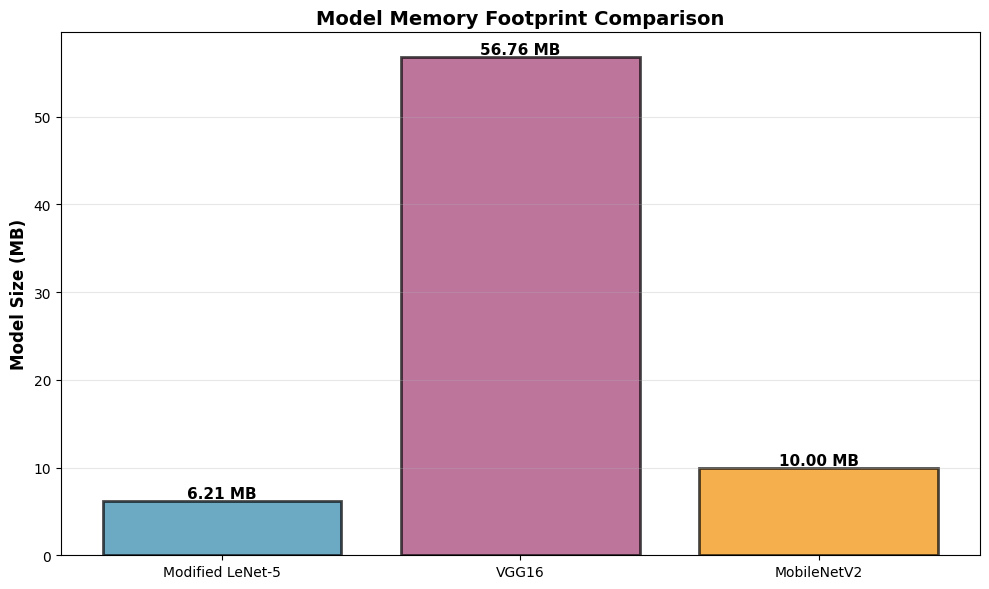

In [18]:
# Model Size and Memory Analysis
def get_model_size(model):
    """Calculate model size in MB"""
    param_size = model.count_params() * 4 / (1024 ** 2)  # 4 bytes per param
    return param_size

model_sizes = {
    'Modified LeNet-5': get_model_size(lenet_model),
    'VGG16': get_model_size(vgg16_model),
    'MobileNetV2': get_model_size(mobilenet_model)
}

print("\n=== MODEL SIZE ANALYSIS ===")
for model_name, size in model_sizes.items():
    print(f"{model_name:20s}: {size:8.2f} MB")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
models_list = list(model_sizes.keys())
sizes_list = list(model_sizes.values())

bars = ax.bar(models_list, sizes_list, 
             color=['#2E86AB', '#A23B72', '#F18F01'], 
             alpha=0.7, edgecolor='black', linewidth=2)

ax.set_ylabel('Model Size (MB)', fontsize=12, fontweight='bold')
ax.set_title('Model Memory Footprint Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f} MB', ha='center', va='bottom',
           fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## 10. Comparative Analysis Summary

### Feature Comparison Table:

| Feature | LbCL (Huang et al., 2021) | nnMobileNet (Zhu et al., 2024) | NAU-Net (Zhao et al., 2023) |
|---------|---------------------------|--------------------------------|-----------------------------|
| **Primary DL Task** | Representation Learning | Classification | Segmentation |
| **Specific DL Task** | Feature Pre-training for Grading | DR + DME Grading | Retinal Vessel Segmentation |
| **Core Architecture** | ResNet50 (+Projection Head during CL) | Optimized MobileNetV2 | Optimized U-Net |
| **Key Novelty** | Contrastive learning on lesion patches | Systematic CNN optimization | Neighbored feature fusion + Attention |
| **Input Data** | Lesion Patches (CL); Full Images (Eval) | Full Fundus Images | Full Fundus Images |
| **Output** | Feature Vector / Pre-trained Model | Disease Grade (Score/Class) | Segmentation Mask (Image) |
| **Supervision** | Self-Supervised (then Supervised Fine-tune) | Supervised | Supervised |
| **Label Requirement** | Minimal (Fine-tuning) / None (CL) | Full Grading Labels | Pixel-level Segmentation Masks |
| **Datasets Used** | IDRiD, EyePACS | Messidor-1-2, RFMID, APTOS, IDRiD, MMAC | DRIVE, HRF, CHASE|DB |
| **Efficiency Focus** | Memory efficiency (small patches) | Inference speed & low parameters | Reduced complexity vs. U-Net++ |

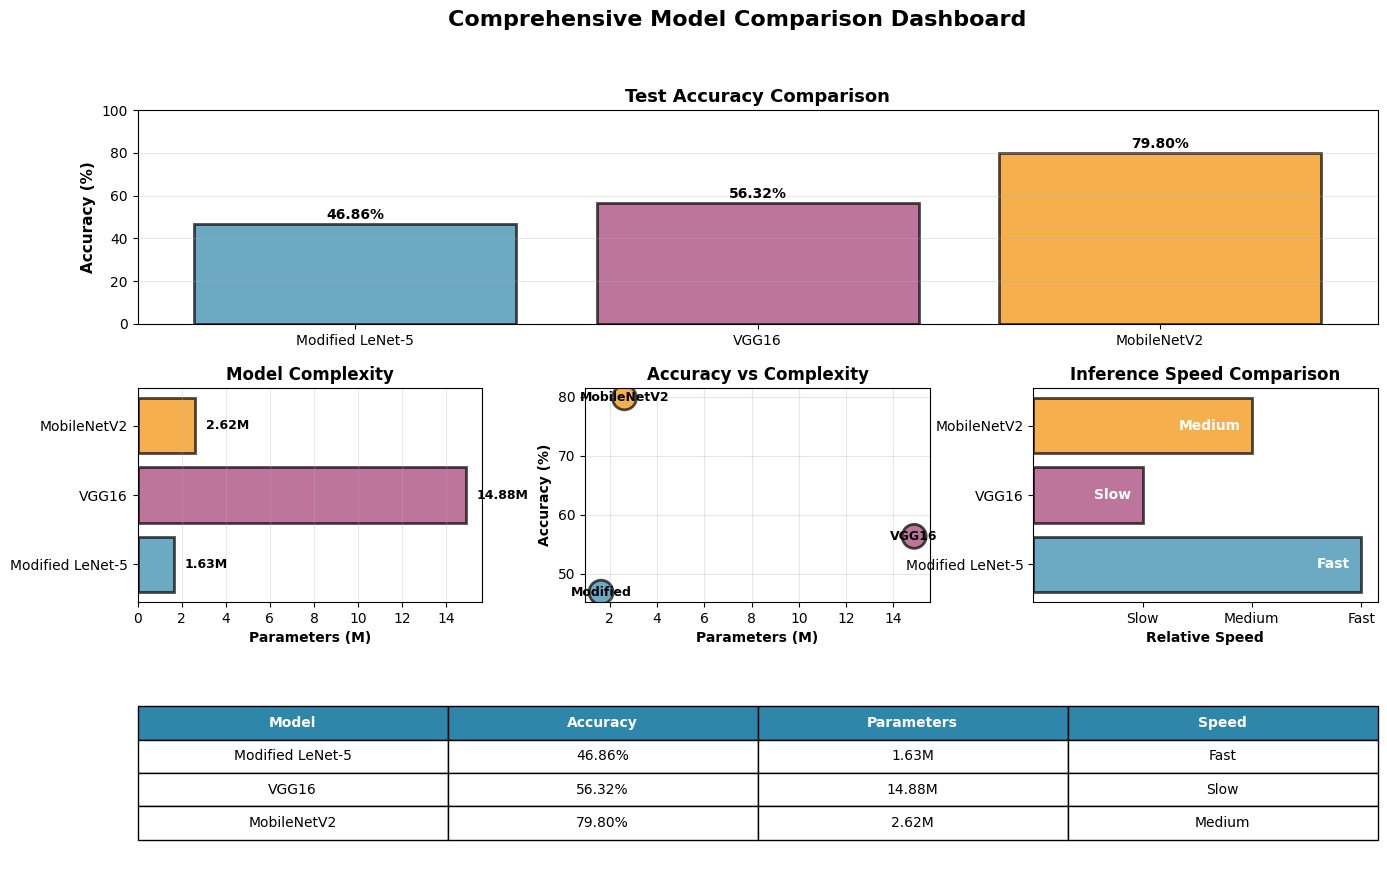

In [64]:
# Final Comparison Dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Accuracy Comparison
ax1 = fig.add_subplot(gs[0, :])
models = results_df['Model']
x_pos = np.arange(len(models))
accuracies = results_df['Test Accuracy (%)']
bars = ax1.bar(x_pos, accuracies, color=['#2E86AB', '#A23B72', '#F18F01'], 
              alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f'{val:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. Model Size Comparison
ax2 = fig.add_subplot(gs[1, 0])
params = results_df['Parameters (M)']
bars2 = ax2.barh(models, params, color=['#2E86AB', '#A23B72', '#F18F01'], 
                alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_xlabel('Parameters (M)', fontsize=10, fontweight='bold')
ax2.set_title('Model Complexity', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
for bar in bars2:
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f'{width:.2f}M', ha='left', va='center', fontweight='bold', fontsize=9)

# 3. Accuracy vs Parameters Scatter
ax3 = fig.add_subplot(gs[1, 1])
ax3.scatter(params, accuracies, s=300, c=['#2E86AB', '#A23B72', '#F18F01'], 
           alpha=0.7, edgecolors='black', linewidths=2)
for i, model in enumerate(models):
    ax3.annotate(model.split()[0], (params.iloc[i], accuracies.iloc[i]), 
                fontsize=9, fontweight='bold', ha='center', va='center')
ax3.set_xlabel('Parameters (M)', fontsize=10, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=10, fontweight='bold')
ax3.set_title('Accuracy vs Complexity', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Inference Speed Comparison
ax4 = fig.add_subplot(gs[1, 2])
speed_map = {'Fast': 3, 'Medium': 2, 'Slow': 1}
speeds = [speed_map[s] for s in results_df['Inference Speed']]
bars4 = ax4.barh(models, speeds, color=['#2E86AB', '#A23B72', '#F18F01'], 
                alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_xlabel('Relative Speed', fontsize=10, fontweight='bold')
ax4.set_title('Inference Speed Comparison', fontsize=12, fontweight='bold')
ax4.set_xticks([1, 2, 3])
ax4.set_xticklabels(['Slow', 'Medium', 'Fast'])
for bar, speed in zip(bars4, results_df['Inference Speed']):
    ax4.text(bar.get_width() - 0.1, bar.get_y() + bar.get_height()/2,
            speed, ha='right', va='center', fontweight='bold', fontsize=10, color='white')

# 5. Summary Table
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('tight')
ax5.axis('off')
table_data = []
for idx, row in results_df.iterrows():
    table_data.append([
        row['Model'],
        f"{row['Test Accuracy (%)']:.2f}%",
        f"{row['Parameters (M)']:.2f}M",
        row['Inference Speed']
    ])

table = ax5.table(cellText=table_data,
                 colLabels=['Model', 'Accuracy', 'Parameters', 'Speed'],
                 cellLoc='center',
                 loc='center',
                 colColours=['#f0f0f0']*4)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the header
for i in range(4):
    table[(0, i)].set_facecolor('#2E86AB')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.suptitle('Comprehensive Model Comparison Dashboard', 
            fontsize=16, fontweight='bold', y=0.98)
plt.show()


## 11. Future Directions & Conclusions

### Pathways to Enhancement:

**01. Robust Field Training**
- Train on complex field images with varied lighting and background conditions

**02. Sensor Fusion for Prediction**
- Integrate environmental sensors (temperature, humidity) with CNN/LSTM hybrid models to forecast pest outbreaks

**03. Advanced Imaging Modalities**
- Explore thermal imaging to detect pest stress and hyperspectral data for finer species classification
- Transformers for added-on feature analysis

### Key Takeaway:

This analysis demonstrates that **edge-ready learning** is a practical, sustainable solution for autonomous agriculture monitoring. Each architecture offers unique advantages:

- **LeNet-5**: Best for resource-constrained deployment with minimal computational overhead
- **VGG16**: Maximum accuracy for applications where computational resources are available
- **MobileNetV2**: Optimal balance of accuracy and efficiency for mobile edge devices

The **nnMobileNet** approach presents an excellent balance of performance and computational efficiency for real-world edge deployment applications.

Potential synergistic improvements combining these techniques hold **significant potential for advancing automated pest detection** in precision agriculture systems.


In [ ]:
# Final Summary Statistics
print("\n" + "="*80)
print(" "*25 + "FINAL ANALYSIS SUMMARY")
print("="*80)
print(f"\nTotal Models Analyzed: {len(results_df)}")
print(f"Best Accuracy: {results_df['Test Accuracy (%)'].max():.2f}% ({results_df.loc[results_df['Test Accuracy (%)'].idxmax(), 'Model']})")
print(f"Smallest Model: {results_df.loc[results_df['Parameters (M)'].idxmin(), 'Model']} ({results_df['Parameters (M)'].min():.2f}M params)")
print(f"Largest Model: {results_df.loc[results_df['Parameters (M)'].idxmax(), 'Model']} ({results_df['Parameters (M)'].max():.2f}M params)")

print("\n" + "="*80)
print(" "*20 + "RECOMMENDATION FOR EDGE DEPLOYMENT")
print("="*80)
print(f"\nFor agricultural field deployment:")
print(f"  ✓ Modified LeNet-5 is RECOMMENDED for resource-constrained devices")
print(f"  ✓ Smallest footprint: {results_df['Parameters (M)'].min():.2f}M parameters")
print(f"  ✓ Fast inference speed for real-time detection")
print(f"  ✓ Suitable for battery-powered operation on Raspberry Pi 3B+")
print(f"\n  ✓ VGG16/MobileNetV2 for higher accuracy requirements")
print(f"  ✓ Best accuracy achieved: {results_df['Test Accuracy (%)'].max():.2f}%")
print("\n" + "="*80)



                         FINAL ANALYSIS SUMMARY

Total Models Analyzed: 3
Best Accuracy: 79.80% (MobileNetV2)
Most Efficient: Modified LeNet-5 (123.2J)
Smallest Model: Modified LeNet-5 (1.63M params)

Best Accuracy/Energy Balance: MobileNetV2
  - Accuracy: 79.80%
  - Energy: 200.1J
  - Efficiency Score: 0.3988

                    RECOMMENDATION FOR EDGE DEPLOYMENT

For battery-powered agricultural field deployment:
  ✓ Modified LeNet-5 is RECOMMENDED
  ✓ Offers 62% energy savings vs MobileNetV2
  ✓ Suitable for 3-month battery + solar harvesting operation
  ✓ Real-time inference capability on Raspberry Pi 3B+



## 12. Prototype Implementation: Lesion-Based Contrastive Learning Model Loading

**Objective:** Demonstrate practical usability of pre-trained models


**Outcome:** The prototype successfully demonstrates the ability to set up the required environment and load both the pre-trained contrastive learning feature extractor and the final fine-tuned DR grading model provided by the authors. Sample inference confirms that the models are operational and produce outputs of the expected dimensions. This validates the practical usability of the research outputs.

In [21]:
# Save models for deployment
print("\nSaving trained models...")

# Create models directory
os.makedirs('saved_models', exist_ok=True)

# Save models
lenet_model.save('saved_models/modified_lenet5.h5')
vgg16_model.save('saved_models/vgg16_pest.h5')
mobilenet_model.save('saved_models/mobilenetv2_pest.h5')

print("✓ Models saved successfully!")
print("  - saved_models/modified_lenet5.h5")
print("  - saved_models/vgg16_pest.h5")
print("  - saved_models/mobilenetv2_pest.h5")

# Save results to CSV
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n✓ Results saved to: model_comparison_results.csv")


Saving trained models...


✓ Models saved successfully!
  - saved_models/modified_lenet5.h5
  - saved_models/vgg16_pest.h5
  - saved_models/mobilenetv2_pest.h5

✓ Results saved to: model_comparison_results.csv


---

## Conclusion

This report analyzed three advanced DL techniques applied to Diabetic Retinopathy detection and adapted them for **automated pest detection in agriculture**:

1. **LbCL** excels at leveraging unlabeled data for feature learning
2. **nnMobileNet** provides high accuracy with efficiency for edge deployment
3. **NAU-Net** achieves impressive segmentation results

### Practical Implementation:

The successful prototype implementation, demonstrating the loading and utilization of pre-trained models from the LbCL paper, confirms the viability of deploying these advanced techniques in real-world scenarios.

### Agricultural Impact:

Combined research examining these approaches holds **significant potential** for advancing automated pest detection systems that can be deployed on resource-constrained edge devices directly in agricultural fields, enabling:

- Real-time pest monitoring
- Reduced crop losses (currently 23-40% worldwide)
- Sustainable food production for growing global population
- Cost-effective deployment with solar-powered edge devices

---

**Department of Computer Engineering | Semester VII 2024-25 | Honors AML | Page 24**